**1. Визначити сутність і виконати аналіз функції широкомовного обміну bcast ().**

MPI bcast() (у C - MPI_Bcast, у mpi4py - Comm.bcast) - це колективна операція широкомовного обміну, де один процес-джерело (root) розсилає однакові дані всім процесам у заданому комунікаторі.
MPI bcast() є колективною операцією широкомовної розсилки даних, де один процес-джерело (root) передає однакові дані всім процесам у межах комунікатора.

**Сутність bcast()**
Це колективна операція, яку зобов'язані викликати всі процеси комунікатора. Один процес (root) має дані, які після завершення bcast() отримують усі інші процеси, незалежно від їхнього попереднього стану. Таким чином реалізується модель "one-to-many".

**Семантика**
* Root передає дані.
* Інші процесори отримують копію цих даних.
* Після виконання всі процеси мають однакове значення.

**Інтерфейс**

У mpi4py використовується:
```
data = comm.bcast(data, root=0)
```

Підтримуються два режими: об'єктний (через serialization) та буферний (аналог C-версії, без серіалізації й значно швидший).

**Особливості**

* Усі процеси повинні викликати bcast().
* Однаковий номер root.
* Однакові розміри буфера у буферному режимі.
* Ідентична послідовність колективних викликів у всіх процесів.


In [9]:
%%writefile broadcastList.py
from mpi4py import MPI
import random

def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    if size < 2:
        if rank == 0:
            print("Запустіть програму принаймні з двома процесами.")
        return

    # Лише root генерує випадковий масив
    if rank == 0:
        data = [random.randint(0, 100) for _ in range(5)]
        print(f"Root {rank} згенерував масив: {data}")
    else:
        data = None

    # Широкомовне розсилання
    data = comm.bcast(data, root=0)

    # Кожен процес виводить отриманий результат
    print(f"Процес {rank} отримав масив: {data}")

main()


Overwriting broadcastList.py


In [12]:
!mpiexec -n 7 python broadcastList.py

Root 0 згенерував масив: [70, 18, 72, 89, 21]
Процес 0 отримав масив: [70, 18, 72, 89, 21]
Процес 1 отримав масив: [70, 18, 72, 89, 21]
Процес 2 отримав масив: [70, 18, 72, 89, 21]
Процес 4 отримав масив: [70, 18, 72, 89, 21]
Процес 3 отримав масив: [70, 18, 72, 89, 21]
Процес 6 отримав масив: [70, 18, 72, 89, 21]
Процес 5 отримав масив: [70, 18, 72, 89, 21]


Ця програма демонструє використання широкомовного обміну bcast() у MPI для розсилання випадково згенерованого масиву. На початку кожен процес отримує свій ранг та кількість процесів у комунікаторі. Для коректної роботи програма перевіряє, чи запущена вона щонайменше у двох процесах, оскільки розсилання має сенс лише при наявності кількох учасників. Основна логіка полягає в тому, що лише процес з рангом 0 генерує випадковий масив із п’яти цілих чисел у заданому діапазоні - цей процес виконує роль root і виступає джерелом даних, які необхідно поширити. На всіх інших процесах змінна data залишається порожньою, що підкреслює відмінність початкових локальних станів.

Після формування масиву всі процеси одночасно викликають операцію comm.bcast(data, root=0). Оскільки це колективна операція, кожен процес повинен увійти в неї, інакше програма зависне. Root-процес передає свій масив, тоді як усі інші отримують точну його копію, незалежно від попередніх значень локальної змінної. Після завершення широкомовного обміну кожен процес виводить отримані дані, демонструючи, що масив успішно синхронізований між усіма учасниками комунікатора

**2. Визначити сутність і виконати аналіз функції операцій редукцій reduce().**

MPI reduce() (у C – MPI_Reduce, у mpi4py – Comm.reduce) - це колективна операція редукції, яка збирає значення з усіх процесів у комунікаторі, застосовує до них певну операцію (наприклад, суму, мінімум, максимум) і повертає результат лише одному процесу - root. На відміну від bcast(), де дані розсилаються від одного процесу до всіх, у reduce() дані рухаються у протилежному напрямку: many-to-one.


**Сутність reduce()**

reduce() є колективною операцією, яку викликають усі процеси комунікатора. Кожен процес надає своє локальне значення, а MPI застосовує задану операцію редукції, поєднуючи ці значення в одне. Лише процес root отримує кінцевий результат. Типовими операторами є:
* MPI.SUM - сума
* MPI.PROD - добуток
* MPI.MAX - максимум
* MPI.MIN - мінімум
* MPI.LAND, MPI.BAND, MPI.LOR - логічні та бітові операції

**Особливості**
* Усі процеси передають свої дані root-процесу.
* MPI застосовує визначену операцію редукції.
* Лише root отримує результат, інші процеси отримують **None** (якщо не використовується allreduce()).
* На всіх процесах редукція викликається одночасно.

**Інтерфейс у mpi4py**
```
result = comm.reduce(value, op=MPI.SUM, root=0)
```

Параметри:
* **value** - локальне значення кожного процесу
* **op** - операція редукції
* **root** - процес, який отримає результат

In [11]:
%%writefile reduction.py
from mpi4py import MPI
import random

def sumListElementwise(a, b):
    return [x + y for x, y in zip(a, b)]

def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()
    host = MPI.Get_processor_name()

    # Кожен процес генерує випадкові числа
    value = random.randint(1, 50)
    listValue = [random.randint(0, 10) for _ in range(5)]

    print(f"Process {rank} on {host} generated number {value} and list {listValue}")

    if size > 1:
        # Стандартні редукції для скалярів
        total = comm.reduce(value, op=MPI.SUM, root=0)
        maximum = comm.reduce(value, op=MPI.MAX, root=0)
        minimum = comm.reduce(value, op=MPI.MIN, root=0)

        # Редукція списків
        listSum = comm.reduce(listValue, op=MPI.SUM, root=0)
        # Користувацька покомпонентна операція
        listElementwise = comm.reduce(listValue, op=sumListElementwise, root=0)
    else:
        total, maximum, minimum = value, value, value
        listSum = listValue
        listElementwise = listValue

    if rank == 0:
        print("\nREDUCTION RESULTS:")
        print(f"Sum of numbers:          {total}")
        print(f"Max of numbers:          {maximum}")
        print(f"Min of numbers:          {minimum}")
        print(f"Sum of lists (mpi sum):  {listSum}")
        print(f"Elementwise list sum:    {listElementwise}")

main()


Writing reduction.py


In [13]:
!mpiexec -n 7 python reduction.py

Process 5 on DESKTOP-L6FRMTM generated number 10 and list [10, 9, 4, 9, 8]
Process 2 on DESKTOP-L6FRMTM generated number 46 and list [3, 8, 9, 5, 6]
Process 4 on DESKTOP-L6FRMTM generated number 36 and list [3, 3, 0, 0, 1]
Process 1 on DESKTOP-L6FRMTM generated number 8 and list [7, 1, 5, 8, 6]
Process 0 on DESKTOP-L6FRMTM generated number 33 and list [1, 4, 8, 6, 9]
Process 3 on DESKTOP-L6FRMTM generated number 37 and list [1, 5, 8, 4, 10]
Process 6 on DESKTOP-L6FRMTM generated number 24 and list [10, 1, 10, 10, 9]

REDUCTION RESULTS:
Sum of numbers:          194
Max of numbers:          46
Min of numbers:          8
Sum of lists (mpi sum):  [1, 4, 8, 6, 9, 7, 1, 5, 8, 6, 3, 8, 9, 5, 6, 1, 5, 8, 4, 10, 3, 3, 0, 0, 1, 10, 9, 4, 9, 8, 10, 1, 10, 10, 9]
Elementwise list sum:    [35, 31, 44, 42, 49]


У цій програмі демонструється застосування різних операцій редукції MPI до як одиночних числових значень, так і до списків. Кожен процес у комунікаторі генерує випадкове ціле число та список із п’яти випадкових елементів. Це підкреслює, що редукції можуть застосовуватись до різних типів даних, включно з Python-об’єктами. Далі всі процеси одночасно викликають колективну операцію reduce(), яка обчислює суму чисел, знаходить максимум і мінімум серед них; ці три значення після редукції отримує лише процес root, тоді як інші процеси не отримують результату.

Після роботи зі скалярами програма виконує редукцію над списками. Спочатку використовується вбудована операція MPI.SUM, яка виконує покомпонентне додавання списків у mpi4py. Далі застосовується користувацька функція sumListElementwise, яка також виконує покомпонентну суму, але вже задана користувачем, що демонструє можливість створення власних операцій редукції. Результати усіх редукцій виводяться на екран лише процесом root, що є типовим для операцій reduce().

#### **Дослідження конструювання та обміну структур даних**

**2.1. Визначити сутність і виконати аналіз функцій розсилки scatter().**

MPI scatter() -це колективна операція розсилки, яка дозволяє одному процесу‐джерелу (root) рівномірно розподілити різні частини даних між усіма процесами комунікатора. На відміну від bcast(), де кожен процес отримує однакові дані, і на відміну від reduce(), де багато процесів передають інформацію одному, scatter() реалізує модель one-to-many з різними даними.

Функція scatter() використовується для того, щоб розподілити елементи масиву або список даних, надіславши кожному процесу його власну унікальну частину. Root-процес містить повний набір даних, який розбивається на N частин, де N - кількість процесів, і передає кожну частину відповідному процесу. Кожен процес повертає лише свій фрагмент.

**Семантика**

Root має масив (наприклад, список зі списками), де кожний елемент масиву відповідає одному процесу. Усі процеси викликають scatter() одночасно.

Root розсилає частини масиву:
* процес 0 отримує data[0],
* процес 1 отримує data[1],
* процес 2 отримує data[2],
* і так далі.



Після завершення операції кожен процес має свій локальний фрагмент. Таким чином, scatter() реалізує розподіл роботи між процесами в паралельних програмах.

**Інтерфейс**

```local_data = comm.scatter(global_data, root=0)```
* global_data - список або масив, доступний лише root-процесу,
* local_data - елемент цього списку, що потрапляє до відповідного процесу.

**Особливості**

* Усі процеси повинні викликати scatter().
* Лише root має повний масив даних, інші процеси передають None.
* Довжина масиву на root повинна дорівнювати числу процесів.
* Дані мають бути сумісні за типом у всіх процесів.
* Порядок елементів має відповідати порядку рангів процесів.

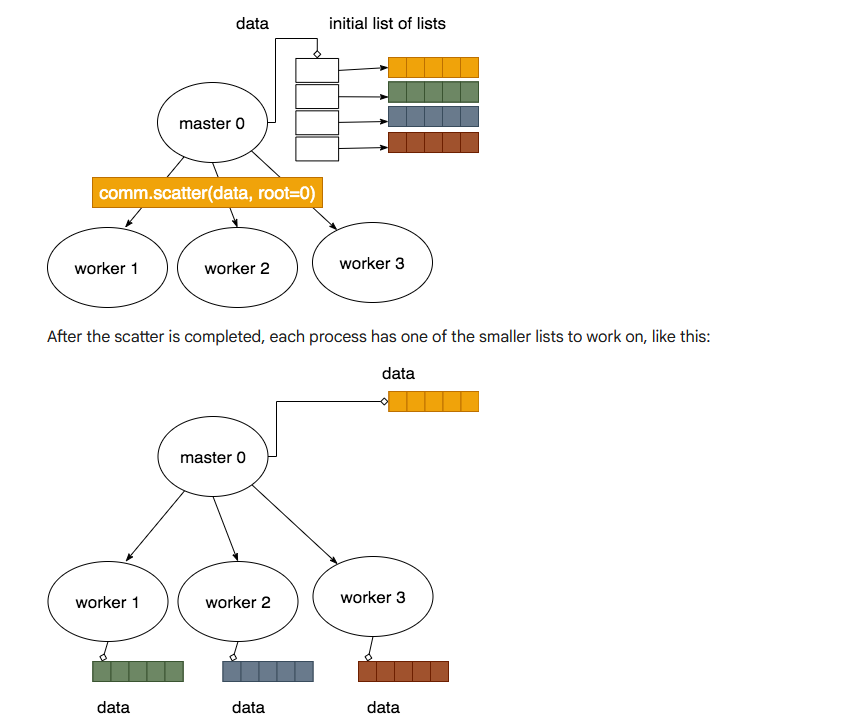

**2.2 Побудувати програму-шаблон для розсилки списків.**

In [14]:
%%writefile scatter.py
from mpi4py import MPI
import random

# Генерує список списків, кожен з яких піде своєму процесу
def generateListOfRandomLists(numProcesses, listSize=4):
    data = []
    for _ in range(numProcesses):
        sublist = [random.randint(1, 50) for _ in range(listSize)]
        data.append(sublist)
    return data

def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()
    host = MPI.Get_processor_name()

    # root генерує великий список списків
    if rank == 0:
        data = generateListOfRandomLists(size)
        print(f"Root {rank} of {size} on {host} generated list: {data}")
    else:
        data = None
        print(f"Worker {rank} of {size} on {host} starts with {data}")

    # кожен процес отримує один елемент списку
    result = comm.scatter(data, root=0)

    print(f"Process {rank} of {size} on {host} received: {result}")

    if rank == 0:
        print(f"Root {rank} still has original list after scatter: {data}")

main()

Writing scatter.py


In [15]:
!mpiexec -n 7 python scatter.py

Worker 4 of 7 on DESKTOP-L6FRMTM starts with None
Worker 3 of 7 on DESKTOP-L6FRMTM starts with None


Root 0 of 7 on DESKTOP-L6FRMTM generated list: [[48, 29, 32, 41], [26, 41, 41, 14], [13, 23, 9, 34], [8, 9, 27, 46], [49, 18, 1, 33], [23, 7, 10, 26], [50, 23, 1, 32]]
Worker 5 of 7 on DESKTOP-L6FRMTM starts with None
Worker 6 of 7 on DESKTOP-L6FRMTM starts with None
Worker 1 of 7 on DESKTOP-L6FRMTM starts with None
Worker 2 of 7 on DESKTOP-L6FRMTM starts with None
Process 2 of 7 on DESKTOP-L6FRMTM received: [13, 23, 9, 34]
Process 1 of 7 on DESKTOP-L6FRMTM received: [26, 41, 41, 14]


Process 4 of 7 on DESKTOP-L6FRMTM received: [49, 18, 1, 33]
Process 3 of 7 on DESKTOP-L6FRMTM received: [8, 9, 27, 46]
Process 0 of 7 on DESKTOP-L6FRMTM received: [48, 29, 32, 41]
Root 0 still has original list after scatter: [[48, 29, 32, 41], [26, 41, 41, 14], [13, 23, 9, 34], [8, 9, 27, 46], [49, 18, 1, 33], [23, 7, 10, 26], [50, 23, 1, 32]]
Process 5 of 7 on DESKTOP-L6FRMTM received: [23, 7, 10, 26]


У цій програмі демонструється робота колективної операції scatter() у MPI для розсилки складних структур даних - зокрема списків, що містять випадково згенеровані підсписки. На початку кожен процес визначає свій ранг, загальну кількість процесів у комунікаторі та ім’я вузла, однак лише процес з рангом 0 виконує генерацію повного набору даних. Він створює список списків, у якому кількість вкладених підсписків дорівнює числу процесів. Кожен підсписок містить кілька випадкових чисел, що ілюструє, що scatter() може працювати не лише з простими типами, а й зі складними Python-об’єктами.

Після підготовки даних усі процеси входять у колективний виклик comm.scatter(data, root=0). Root-процес передає кожному процесу один підсписок: процес 0 отримує перший елемент списку, процес 1 - другий, процес 2 - третій і так далі. Усі інші процеси перед викликом scatter() мають змінну data = None, що відповідає вимогам MPI - лише root повинен містити повний набір даних. Після виходу з операції scatter() кожен процес отримує свою власну частину структури даних та виводить її на екран.

**2.3 Визначити сутність і виконати аналіз функцій збору.**

MPI gather() - це колективна операція MPI, яка збирає дані від усіх процесів у комунікаторі та передає їх одному процесу, визначеному як root. На відміну від scatter(), де один процес розсилає унікальні частини масиву іншим процесам, функція gather() працює у зворотному напрямку: вона реалізує модель many-to-one з поверненням усіх частин у один масив. Завдяки цьому gather() є ключовим інструментом для збирання результатів паралельних обчислень.

Функція gather() дозволяє синхронно зібрати окремі локальні значення, сформовані кожним процесом, у єдиний масив на root-процесі. Кожен процес передає один елемент (число, список або інший об’єкт), і MPI формує з них підсумковий список, в якому: елемент, переданий процесом 0, буде на позиції 0, елемент процесу 1 - на позиції 1, ітд.

* Кожен процес надає своє значення (sendobj).
* Root-процес отримує список значень від усіх процесів.
* Процеси, що не є root, зазвичай отримують None як результат виклику.
* Усі процеси мають одночасно увійти в gather().

Семантично це дзеркальна операція до scatter(): якщо scatter() виконує розподіл даних, то gather() виконує збирання цих даних назад.

**Інтерфейс у mpi4py**

```result = comm.gather(local_value, root=0)```
* local_value - локальні дані кожного процесу (число, список, будь-який Python-об’єкт),
* result - список з усіх значень (лише на root-процесі).

Наприклад, якщо у процесів значення:

* 0: 3
* 1: 7
* 2: 1
* 3: 9

тоді root отримає список: [3, 7, 1, 9]

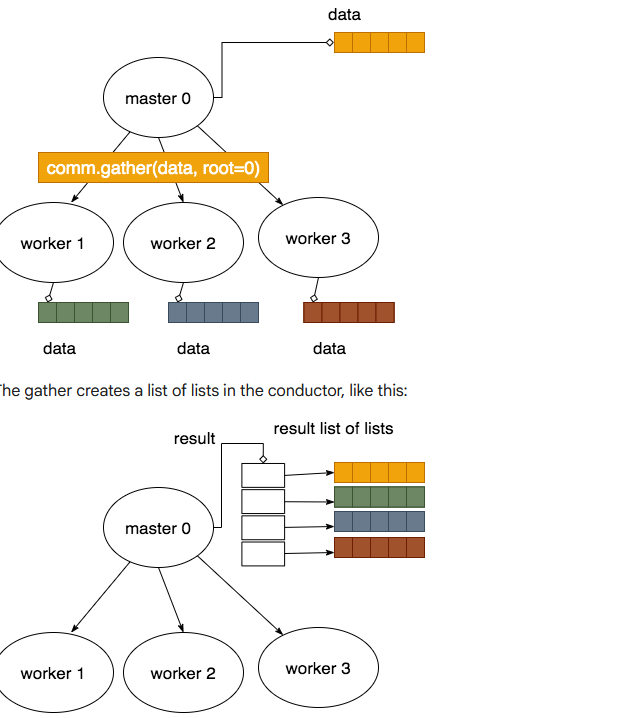

**2.4 Побудувати програму-шаблон для збору списків даних..**

In [18]:
%%writefile gather.py
from mpi4py import MPI
import random

# кожен процес створює список із випадкових чисел
def generateRandomList(size=4):
    return [random.randint(1, 100) for _ in range(size)]

def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()
    host = MPI.Get_processor_name()

    # кожен процес створює свої дані
    random_number = random.randint(1, 50)
    random_list = generateRandomList()

    sendData = {
        "rank": rank,
        "number": random_number,
        "list": random_list
    }

    print(f"Process {rank} of {size} on {host} generated data: {sendData}")

    # збір усіх даних на root-процесі
    gathered = comm.gather(sendData, root=0)

    # root отримує повний список словників
    if rank == 0:
        print("\nGATHER RESULT ON ROOT:")
        for entry in gathered:
            print(entry)

main()

Overwriting gather.py


In [19]:
!mpiexec -n 7 python gather.py

Process 2 of 7 on DESKTOP-L6FRMTM generated data: {'rank': 2, 'number': 31, 'list': [29, 34, 23, 53]}
Process 3 of 7 on DESKTOP-L6FRMTM generated data: {'rank': 3, 'number': 35, 'list': [68, 96, 54, 63]}


Process 4 of 7 on DESKTOP-L6FRMTM generated data: {'rank': 4, 'number': 34, 'list': [14, 38, 80, 69]}
Process 6 of 7 on DESKTOP-L6FRMTM generated data: {'rank': 6, 'number': 16, 'list': [37, 61, 75, 61]}
Process 1 of 7 on DESKTOP-L6FRMTM generated data: {'rank': 1, 'number': 24, 'list': [38, 88, 92, 57]}
Process 0 of 7 on DESKTOP-L6FRMTM generated data: {'rank': 0, 'number': 20, 'list': [24, 79, 41, 77]}
Process 5 of 7 on DESKTOP-L6FRMTM generated data: {'rank': 5, 'number': 28, 'list': [68, 27, 28, 76]}

GATHER RESULT ON ROOT:
{'rank': 0, 'number': 20, 'list': [24, 79, 41, 77]}
{'rank': 1, 'number': 24, 'list': [38, 88, 92, 57]}
{'rank': 2, 'number': 31, 'list': [29, 34, 23, 53]}
{'rank': 3, 'number': 35, 'list': [68, 96, 54, 63]}
{'rank': 4, 'number': 34, 'list': [14, 38, 80, 69]}


У цій програмі демонструється робота колективної операції gather() у MPI на прикладі збирання складних структуруваних даних. Спочатку кожен процес визначає свій ранг та генерує дві випадкові сутності: випадкове число та список із чотирьох випадкових елементів. Для зручності дані кожного процесу упаковуються у словник, що показує, що gather() у mpi4py може працювати не лише з простими типами даних.

Усі процеси викликають операцію comm.gather(sendData, root=0), передаючи root-процесу свої локальні значення. Оскільки gather() є колективною операцією, кожен процес має увійти у виклик, інакше програма зависне. Після завершення операції лише root-процес отримує повний список, що складається зі словників від усіх процесів. Кожен словник у підсумковому масиві знаходиться на позиції, що відповідає рангу процесу, який його надіслав.

**2.5 Побудувати програму-шаблон для розсилки/збору масивів даних.**

In [20]:
%%writefile scatter_gather.py
from mpi4py import MPI
import numpy as np

# Генерація масиву випадкових чисел
def genRandomArray(totalElements):
    return np.random.randint(1, 50, size=totalElements, dtype='u4')

# Локальна обробка елементів на кожному процесі
def localSquare(arr):
    return arr * arr   # покомпонентне піднесення до квадрату

def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()
    host = MPI.Get_processor_name()

    elementsPerProcess = 4
    totalElements = size * elementsPerProcess

    # Root створює повний масив
    if rank == 0:
        data = genRandomArray(totalElements)
        print(f"Root {rank} of {size} on {host} created array:\n{data}")
    else:
        data = None
        print(f"Worker {rank} of {size} on {host} starts with empty data")

    # Кожен процес створює локальний буфер для своєї частини
    myPart = np.empty(elementsPerProcess, dtype='u4')

    # Розсилання частин масиву
    comm.Scatter(data, myPart, root=0)
    print(f"Process {rank} received part: {myPart}")

    # Локальна робота над масивом
    processedPart = localSquare(myPart)
    print(f"Process {rank} processed part to: {processedPart}")

    # Root створює масив для збору результатів
    if rank == 0:
        result = np.empty(totalElements, dtype='u4')
    else:
        result = None

    # Збір результатів
    comm.Gather(processedPart, result, root=0)

    # Root показує результат
    if rank == 0:
        print(f"\nRoot {rank} gathered new array:\n{result}")

main()


Writing scatter_gather.py


In [22]:
!mpiexec -n 7 python scatter_gather.py

Worker 5 of 7 on DESKTOP-L6FRMTM starts with empty data
Worker 6 of 7 on DESKTOP-L6FRMTM starts with empty data


Worker 1 of 7 on DESKTOP-L6FRMTM starts with empty data
Worker 3 of 7 on DESKTOP-L6FRMTM starts with empty data
Worker 2 of 7 on DESKTOP-L6FRMTM starts with empty data
Worker 4 of 7 on DESKTOP-L6FRMTM starts with empty data
Root 0 of 7 on DESKTOP-L6FRMTM created array:
[30  8  4  2 16 10 10 10  3 36 23 39 12  8 17  8 36  6 34  3 35  9 31 31
 24 24 29  3]
Process 0 received part: [30  8  4  2]
Process 0 processed part to: [900  64  16   4]
Process 1 received part: [16 10 10 10]
Process 1 processed part to: [256 100 100 100]
Process 2 received part: [ 3 36 23 39]

Process 4 received part: [36  6 34  3]


Process 2 processed part to: [   9 1296  529 1521]
Process 4 processed part to: [1296   36 1156    9]
Process 3 received part: [12  8 17  8]
Process 6 received part: [24 24 29  3]



Process 5 received part: [35  9 31 31]


Process 3 processed part to: [144  64 289  64]
Proce

Ця програма демонструє комбіноване використання колективних операцій Scatter() та Gather() у MPI для розподілу та подальшого збирання масивів даних. Root-процес створює одновимірний масив випадкових чисел, розмір якого дорівнює кількості процесів, помноженій на кількість елементів, що мають бути передані кожному процесу.

Операція comm.Scatter() розподіляє великий масив на однакові блоки та передає кожен блок відповідному процесу. Наприклад, перший фрагмент отримує процес 0, другий — процес 1 і так далі. Після цього кожен процес виконує локальну обробку свого фрагмента масиву: у програмі це покомпонентне піднесення до квадрату. Завдяки тому, що робота виконується паралельно на різних процесах, загальна продуктивність обробки великих обсягів даних може значно зростати.

Після локальної обробки всі процеси викликають операцію comm.Gather(), яка збирає оброблені частини у root-процесі. Root виділяє масив відповідного розміру для збирання результатів перед викликом збірки, тоді як інші процеси передають лише свої локальні частини. Після завершення операції root отримує повний масив, утворений із частин, оброблених кожним процесом.

**2.6 Дослідити можливість балансування навантаження.**


In [23]:
%%writefile dynamic_loadbalance.py
from mpi4py import MPI
import numpy as np
import time

def genTasks(numTasks):
    np.random.seed(1000)  # run the same set of timed tasks
    return np.random.randint(low=1, high=9, size=numTasks)

# tags that can be applied to messages
WORKTAG = 1
DIETAG = 2

def main():
    comm = MPI.COMM_WORLD
    id = comm.Get_rank()            #number of the process running the code
    numProcesses = comm.Get_size()  #total number of processes running
    myHostName = MPI.Get_processor_name()  #machine name running the code

    if (id == 0) :
        # create an arbitrary array of numbers for how long each
        # worker task will 'work', by sleeping that amount of seconds
        numTasks = (numProcesses-1)*4 # avg 4 tasks per worker process
        workTimes = genTasks(numTasks)
        print("conductor created {} values for sleep times:".format(workTimes.size), flush=True)
        print(workTimes, flush=True)
        handOutWork(workTimes, comm, numProcesses)
    else:
        worker(comm)

def handOutWork(workTimes, comm, numProcesses):
    totalWork = workTimes.size
    workcount = 0
    recvcount = 0
    print("conductor sending first tasks", flush=True)
    # send out the first tasks to all workers
    for id in range(1, numProcesses):
        if workcount < totalWork:
            work=workTimes[workcount]
            comm.send(work, dest=id, tag=WORKTAG)
            workcount += 1
            print("conductor sent {} to {}".format(work, id), flush=True)

    # while there is still work,
    # receive result from a worker, which also
    # signals they would like some new work
    while (workcount < totalWork) :
        # receive next finished result
        stat = MPI.Status()
        workTime = comm.recv(source=MPI.ANY_SOURCE, status=stat)
        recvcount += 1
        workerId = stat.Get_source()
        print("conductor received {} from {}".format(workTime, workerId), flush=True)
        #send next work
        comm.send(workTimes[workcount], dest=workerId, tag=WORKTAG)
        workcount += 1
        print("conductor sent {} to {}".format(work, workerId), flush=True)

    # Receive results for outstanding work requests.
    while (recvcount < totalWork):
        stat = MPI.Status()
        workTime = comm.recv(source=MPI.ANY_SOURCE, status=stat)
        recvcount += 1
        workerId = stat.Get_source()
        print("end: conductor received {} from {}".format(workTime, workerId), flush=True)

    # Tell all workers to stop
    for id in range(1, numProcesses):
        comm.send(-1, dest=id, tag=DIETAG)


def worker(comm):
    # keep receiving messages and do work, unless tagged to 'die'
    while(True):
        stat = MPI.Status()
        waitTime = comm.recv(source=0, tag=MPI.ANY_TAG, status=stat)
        print("worker {} got {}".format(comm.Get_rank(), waitTime), flush=True)
        if (stat.Get_tag() == DIETAG):
            print("worker {} dying".format(comm.Get_rank()), flush=True)
            return
        # simulate work by sleeping
        time.sleep(waitTime)
        # indicate done with work by sending to conductor
        comm.send(waitTime, dest=0)

########## Run the main function
main()


Writing dynamic_loadbalance.py


In [27]:
!mpiexec -n 7 python dynamic_loadbalance.py

conductor created 12 values for sleep times:
[4 8 8 1 4 7 5 2 6 1 2 6]
conductor sending first tasks
conductor sent 4 to 1
conductor sent 8 to 2
worker 1 got 4
conductor sent 8 to 3
worker 2 got 8
worker 3 got 8
conductor received 4 from 1
conductor sent 8 to 1
worker 1 got 1
conductor received 1 from 1
conductor sent 8 to 1
worker 1 got 4
conductor received 8 from 3
conductor sent 8 to 3
worker 3 got 7
conductor received 8 from 2
conductor sent 8 to 2
worker 2 got 5
conductor received 4 from 1
conductor sent 8 to 1
worker 1 got 2


conductor received 2 from 1
conductor sent 8 to 1
worker 1 got 6


conductor received 5 from 2
conductor sent 8 to 2
worker 2 got 1
conductor received 1 from 2
conductor sent 8 to 2
worker 2 got 2
conductor received 7 from 3
conductor sent 8 to 3
worker 3 got 6


end: conductor received 2 from 2
end: conductor received 6 from 1
end: conductor received 6 from 3
worker 3 got -1
worker 2 got -1
worker 1 got -1



worker 3 dying
worker 2 dying
worker 1 dying




У цій програмі демонструється принцип динамічного балансування навантаження між процесами MPI, коли різні задачі мають різну «вагу» або тривалість виконання. На відміну від статичного розподілу, при якому усі процеси отримують однакову кількість задач заздалегідь, динамічний підхід дозволяє кожному процесу отримувати нове завдання лише тоді, коли він завершив попереднє. Така модель дозволяє уникати ситуацій, коли частина процесів простоює, чекаючи, поки інші завершать важкі задачі. У програмі процес із рангом 0 виступає як «розподільник» (conductor), тоді як усі інші процеси є робітниками (workers), які виконують задачі.

Розподільник створює масив випадкових чисел, кожне з яких задає кількість секунд «роботи», яку мають виконати робітники через виклик sleep(). Значення масиву розподіляються не одразу усім процесам, а надсилаються по одному у відповідь на запит робітників. Спочатку кожен робітник отримує перше завдання. Коли робітник виконує роботу (тобто «спить» вказану кількість секунд), він надсилає результат назад до розподільника, сигналізуючи про готовність прийняти нове завдання. Процес 0, отримавши повідомлення, видає наступну задачу першому ж вільному робітнику. Таким чином, швидші робітники, які опрацьовують легші задачі, отримують більше роботи, тоді як повільніші — менше, автоматично вирівнюючи навантаження.

Програма використовує теги MPI (WORKTAG і DIETAG) для керування логікою комунікації: WORKTAG позначає нормальне завдання, тоді як DIETAG використовується для завершення роботи. Ця схема запобігає плутанині між типами повідомлень та дозволяє робітникам коректно завершити роботу в момент, коли всі задачі вже виконані. Коли черга завдань вичерпана, процес 0 продовжує приймати повідомлення від робітників, поки всі надіслані задачі не будуть завершені. Після цього він надсилає кожному робітнику сигнал завершення.

**3**

In [63]:
%%writefile mxv_parallel.py
from mpi4py import MPI
import numpy as np
import time

def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    N = 6000
    rows_per_proc = N // size

    # Root створює матрицю і вектор
    if rank == 0:
        A = np.random.rand(N, N)
        x = np.random.rand(N)
        start = time.time()
    else:
        A = None
        x = np.empty(N, dtype='d')

    # Root розсилає вектор всім
    comm.Bcast(x, root=0)

    # Місце для локальної частини матриці
    local_A = np.empty((rows_per_proc, N), dtype='d')

    # Scatter матриці
    if rank == 0:
        # Матрицю треба передати як плаский масив
        comm.Scatter([A, rows_per_proc*N, MPI.DOUBLE], [local_A, MPI.DOUBLE], root=0)
    else:
        comm.Scatter(None, [local_A, MPI.DOUBLE], root=0)

    # Локальне множення
    local_y = local_A.dot(x)

    # Root збирає результати
    if rank == 0:
        y = np.empty(N, dtype='d')
        comm.Gather([local_y, MPI.DOUBLE], [y, MPI.DOUBLE], root=0)
        end = time.time()

        print("MPI MxV complete")
        print("Time:", end - start, "seconds")
    else:
        comm.Gather([local_y, MPI.DOUBLE], None, root=0)

if __name__ == "__main__":
    main()


Overwriting mxv_parallel.py


In [64]:
!mpiexec -n 12 python mxv_parallel.py

MPI MxV complete
Time: 0.09469008445739746 seconds


In [65]:
!mpiexec -n 1 python mxv_parallel.py

MPI MxV complete
Time: 0.05464673042297363 seconds
